# Part 1: Data Preparation

In [95]:
import json
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/antoniostanciu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [96]:
dataset_path = '../../data/fashion_products_dataset.json'
with open(dataset_path, 'r') as file:
    data = json.load(file)

In [97]:
def extract_product_details(details):
    """
    Extracts only the descriptive values from structured product_details.
    Example input: [{"Color": "Blue"}, {"Material": "Cotton"}]
    Output: "Blue Cotton"
    """
    values = []
    for category in details:
        values.extend(v for v in category.values())
    return " ".join(values)

In [98]:
def build_terms(document):
    """
    Preprocess the document text (title + description + product_details extracted) removing stop words, stemming,
    transforming in lowercase and return the tokens of the text.

    Argument:
    document -- a dictionary with 'title' and 'description' keys

    Returns:
    tokens - a list of tokens corresponding to the input text after the preprocessing
    """
    # 1. Stemmer and stop words
    stemmer = PorterStemmer()
    stop_words = set(stopwords.words('english'))

    # 2. Text
    text = document['title'] + ' ' + document['description'] + ' ' + extract_product_details(document['product_details'])
    text = text.lower()
    text = ''.join(char if char.isalnum() or char.isspace() else ' ' for char in text)
    text = text.split(" ")
    text = [term for term in text if term not in stop_words]
    text = [term for term in text if term != '']
    text = [stemmer.stem(term) for term in text]

    return text

In [99]:
def preprocess_document(document):
    """""
    Process the document
    1. Build the tokens of the document
    2. Build the metadata tokens of the document
    3. Build the original attributes of the document
    """

    # 1. Searchable tokens
    tokens = build_terms(document)

    # 2. Metadata tokens
    metadata = {
        'category': document.get('category', '').lower().strip(),
        'sub_category': document.get('sub_category', '').lower().strip(),
        'brand': document.get('brand', '').lower().strip(),
        'seller': document.get('seller', '').lower().strip()
    }

    # 3. Original attributes
    original = {
        "pid": document["pid"],
        "title": document["title"],
        "description": document["description"],
        "brand": document["brand"],
        "category": document["category"],
        "sub_category": document["sub_category"],
        "product_details": document["product_details"],
        "seller": document["seller"],
        "out_of_stock": document["out_of_stock"],
        "selling_price": document["selling_price"],
        "discount": document["discount"],
        "actual_price": document["actual_price"],
        "average_rating": document["average_rating"],
        "url": document["url"]
    }
    return {
        "searchable_text": tokens,
        "metadata": metadata,
        "original": original
    }

In [100]:
print("Processing corpus...")
preprocessed_data = [preprocess_document(doc) for doc in data]
print(f"Total processed products: {len(preprocessed_data)}")

print("="*70)
print("PROCESSED DOCUMENT EXAMPLE")
print("="*70)

sample = preprocessed_data[0]

print(f"\n1. SEARCHABLE TEXT {len(sample['searchable_text'])} tokens):")
print(f"   First 15 tokens: {sample['searchable_text'][:15]}")

print(f"\n2. METADATA:")
print(f"   Brand: '{sample['metadata']['brand']}'")
print(f"   Category: '{sample['metadata']['category']}'")
print(f"   Sub-category: '{sample['metadata']['sub_category']}'")
print(f"   Seller: '{sample['metadata']['seller']}'")

print(f"\n3. ORIGINAL:")
print(f"   PID: {sample['original']['pid']}")
print(f"   Title: {sample['original']['title']}")
print(f"   Price: {sample['original']['selling_price']}")
print(f"   Rating: {sample['original']['average_rating']}")
print(f"   Out of stock: {sample['original']['out_of_stock']}")

Processing corpus...
Total processed products: 28080
PROCESSED DOCUMENT EXAMPLE

1. SEARCHABLE TEXT 38 tokens):
   First 15 tokens: ['solid', 'women', 'multicolor', 'track', 'pant', 'yorker', 'trackpant', 'made', '100', 'rich', 'comb', 'cotton', 'give', 'rich', 'look']

2. METADATA:
   Brand: 'york'
   Category: 'clothing and accessories'
   Sub-category: 'bottomwear'
   Seller: 'shyam enterprises'

3. ORIGINAL:
   PID: TKPFCZ9EA7H5FYZH
   Title: Solid Women Multicolor Track Pants
   Price: 921
   Rating: 3.9
   Out of stock: False


# Part 2: Exploratory Data Analysis

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
import pandas as pd

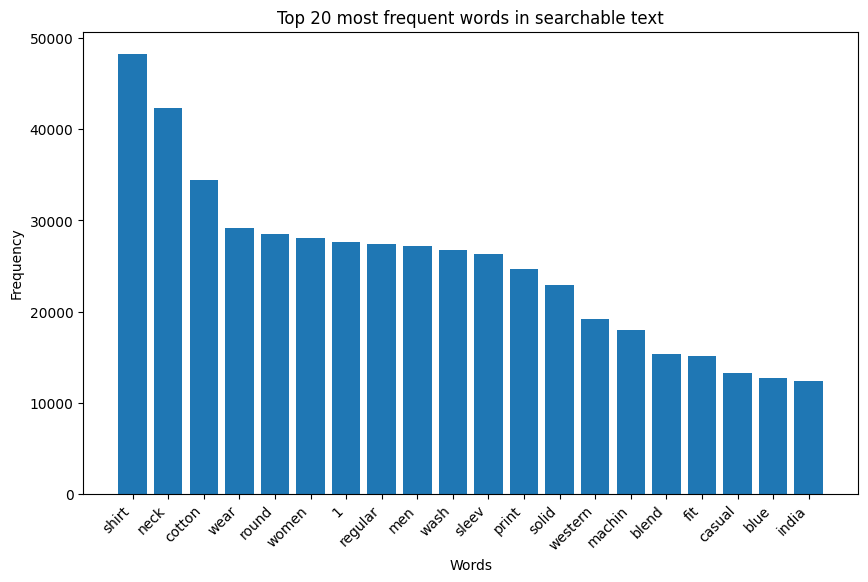

In [102]:
# Flatten the list of tokens from all documents
all_tokens = [token for doc in preprocessed_data for token in doc["searchable_text"]]

# Count the frequency of each word
word_counts = Counter(all_tokens)

# Get the most common words
most_common_words = word_counts.most_common(20)

# Plot the word counting distribution
words, counts = zip(*most_common_words)
plt.figure(figsize=(10, 6))
plt.bar(words, counts)
plt.xticks(rotation=45, ha="right")
plt.title("Top 20 most frequent words in searchable text")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.show()

In [103]:
# Vocabulary statistics
vocabulary = set(all_tokens)
token_counts_per_doc = [len(doc["searchable_text"]) for doc in preprocessed_data]

print(f"\nVocabulary statistics:")
print(f"   Total tokens (with repetitions): {len(all_tokens):,}")
print(f"   Unique terms (vocabulary size): {len(vocabulary):,}")
print(f"   Average tokens per document: {np.mean(token_counts_per_doc):.2f}")
print(f"   Median tokens per document: {np.median(token_counts_per_doc):.0f}")
print(f"   Min tokens: {min(token_counts_per_doc)}")
print(f"   Max tokens: {max(token_counts_per_doc)}")

# Original text lengths (before preprocessing)
title_lengths = [len(doc['original']['title'].split()) for doc in preprocessed_data]
desc_lengths = [len(doc['original']['description'].split()) for doc in preprocessed_data]

print(f"\nOriginal text lengths (words):")
print(f"   Average title length: {np.mean(title_lengths):.2f} words")
print(f"   Average description length: {np.mean(desc_lengths):.2f} words")

print(f"\nMost common terms:")
for i, (term, count) in enumerate(word_counts.most_common(15), 1):
    percentage = (count / len(all_tokens)) * 100
    print(f"   {i:2d}. {term:15s} : {count:6,} ({percentage:5.2f}%)")


Vocabulary statistics:
   Total tokens (with repetitions): 1,393,344
   Unique terms (vocabulary size): 20,906
   Average tokens per document: 49.62
   Median tokens per document: 38
   Min tokens: 3
   Max tokens: 621

Original text lengths (words):
   Average title length: 6.46 words
   Average description length: 29.77 words

Most common terms:
    1. shirt           : 48,293 ( 3.47%)
    2. neck            : 42,330 ( 3.04%)
    3. cotton          : 34,429 ( 2.47%)
    4. wear            : 29,152 ( 2.09%)
    5. round           : 28,535 ( 2.05%)
    6. women           : 28,060 ( 2.01%)
    7. 1               : 27,685 ( 1.99%)
    8. regular         : 27,430 ( 1.97%)
    9. men             : 27,237 ( 1.95%)
   10. wash            : 26,719 ( 1.92%)
   11. sleev           : 26,316 ( 1.89%)
   12. print           : 24,722 ( 1.77%)
   13. solid           : 22,875 ( 1.64%)
   14. western         : 19,189 ( 1.38%)
   15. machin          : 17,947 ( 1.29%)



Brands and Categories:
  Total brands: 321
  Total categories: 4


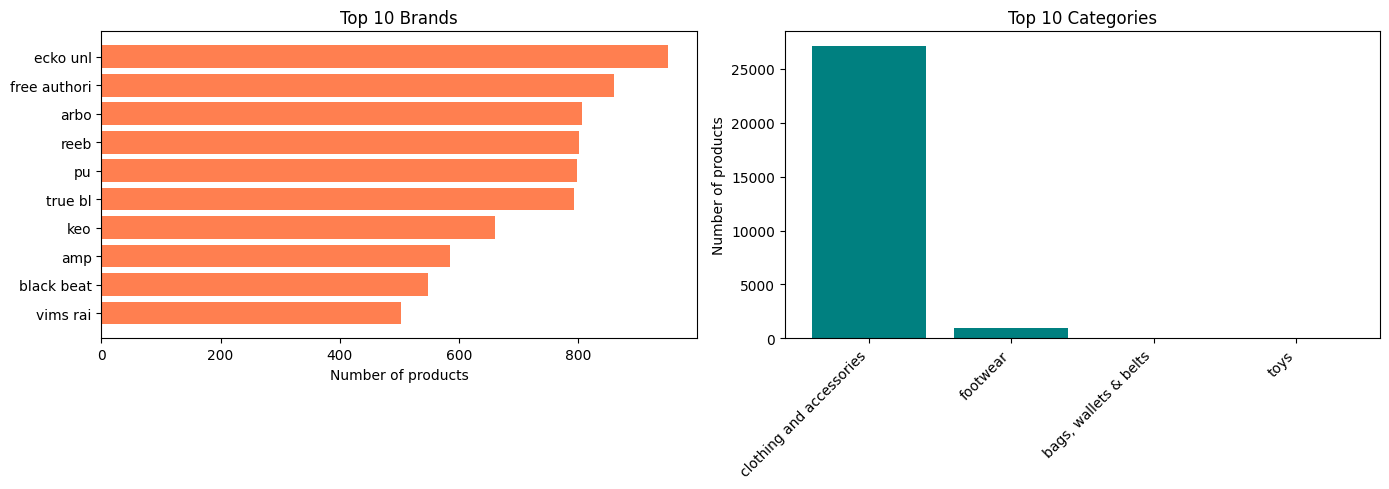

In [104]:
# Extract metadata
brands = [doc["metadata"]["brand"] for doc in preprocessed_data if doc["metadata"]["brand"]]
categories = [doc["metadata"]["category"] for doc in preprocessed_data if doc["metadata"]["category"]]

brand_counts = Counter(brands)
category_counts = Counter(categories)

print(f"\nBrands and Categories:")
print(f"  Total brands: {len(set(brands))}")
print(f"  Total categories: {len(set(categories))}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Top brands
top_brands = brand_counts.most_common(10)
brands_names, brands_values = zip(*top_brands)
axes[0].barh(range(len(brands_names)), brands_values, color='coral')
axes[0].set_yticks(range(len(brands_names)))
axes[0].set_yticklabels(brands_names)
axes[0].invert_yaxis()
axes[0].set_title("Top 10 Brands")
axes[0].set_xlabel("Number of products")

# Top categorías
top_cats = category_counts.most_common(10)
cat_names, cat_values = zip(*top_cats)
axes[1].bar(range(len(cat_names)), cat_values, color="teal")
axes[1].set_xticks(range(len(cat_names)))
axes[1].set_xticklabels([name[:25] for name in cat_names], rotation=45, ha="right")
axes[1].set_title("Top 10 Categories")
axes[1].set_ylabel("Number of products")

plt.tight_layout()
plt.show()

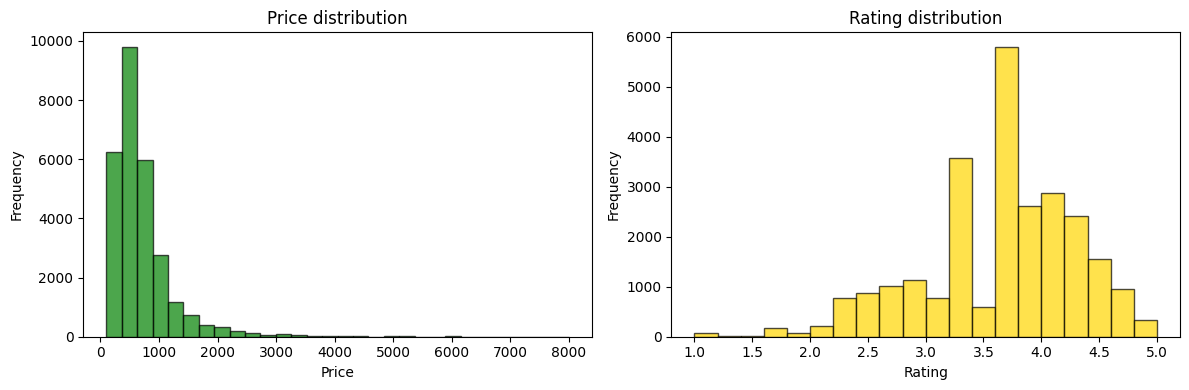

In [105]:
# Extract prices and ratings
prices = []
ratings = []

for doc in preprocessed_data:
    # Price
    try:
        price_str = doc["original"]["selling_price"]
        if price_str:
            price = float(str(price_str).replace(',', ''))
            if price > 0:
                prices.append(price)
    except:
        pass

    # Rating
    try:
        rating_str = doc["original"]["average_rating"]
        if rating_str:
            rating = float(rating_str)
            if rating > 0:
                ratings.append(rating)
    except:
        pass

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Price distribution
axes[0].hist(prices, bins=30, color="green", edgecolor="black", alpha=0.7)
axes[0].set_xlabel("Price")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Price distribution")

# Rating distribution
axes[1].hist(ratings, bins=20, color="gold", edgecolor="black", alpha=0.7)
axes[1].set_xlabel("Rating")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Rating distribution")

plt.tight_layout()
plt.show()

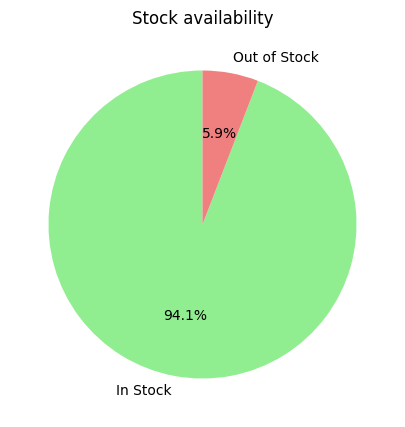

In [106]:
# Stock
out_of_stock = sum(1 for doc in preprocessed_data if doc["original"]["out_of_stock"])
in_stock = len(preprocessed_data) - out_of_stock

# Discounts
discounts = []
for doc in preprocessed_data:
    try:
        discount_str = doc["original"]["discount"]
        if discount_str:
            discount = float(str(discount_str).replace("%", "").replace(" off", "").strip())
            if discount > 0:
                discounts.append(discount)
    except:
        pass

# Pie chart simple
labels = ["In Stock", "Out of Stock"]
sizes = [in_stock, out_of_stock]
colors = ["lightgreen", "lightcoral"]

plt.figure(figsize=(7, 5))
plt.pie(sizes, labels=labels, autopct="%1.1f%%", colors=colors, startangle=90)
plt.title("Stock availability")
plt.show()